test generator

In [4]:
pip install scikit-image

  Using cached scikit_image-0.25.2-cp313-cp313-win_amd64.whl.metadata (14 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached imageio-2.37.2-py3-none-any.whl.metadata (9.7 kB)
  Using cached tifffile-2025.10.16-py3-none-any.whl.metadata (31 kB)
Using cached scikit_image-0.25.2-cp313-cp313-win_amd64.whl (12.9 MB)
Using cached imageio-2.37.2-py3-none-any.whl (317 kB)
Using cached networkx-3.5-py3-none-any.whl (2.0 MB)
Using cached tifffile-2025.10.16-py3-none-any.whl (231 kB)

   ---------------------------------------- 0/4 [tifffile]
   ---------------------------------------- 0/4 [tifffile]
   ---------------------------------------- 0/4 [tifffile]
   ---------- ----------------------------- 1/4 [networkx]
   ---------- ----------------------------- 1/4 [networkx]
   ---------- ----------------------------- 1/4 [networkx]
   ---------- ----------------------------- 1/4 [networkx]
   ---------- ----------------------------- 1/4 [networkx]
   ---------- ----

The value specified in an AutoRun registry key could not be parsed.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
#from data_generator import *

In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from skimage.draw import *

In [6]:
img = np.zeros((500, 500, 3), dtype=np.double)
img = np.zeros((500, 500, 3))

In [7]:
x_radius = 50
y_radius = 20
alpha = 3*np.pi/7
beta = 3*np.pi/15
test = [[(((x-200)*np.cos(alpha) + (y-30)*np.sin(alpha) ) / x_radius) ** 2 + (((x-200)*np.sin(alpha) - (y-30)*np.cos(alpha)) / y_radius) ** 2 - 1 for x in range(500)] for y in range(500)]
noise = -np.random.rand(500,500)*10
blurred = gaussian_filter(noise,sigma=2)
test = np.array(test) + blurred
test = np.where(test < 0, 1, 0)

In [8]:
def generate_cell(c_x,c_y,x_radius,y_radius,alpha,img_size,noise_strength,sigma_blur, class_nbr=1):
    def ellipse(x,y):
        return (((x-c_x)*np.cos(alpha) + (y-c_y)*np.sin(alpha) ) / x_radius) ** 2 + (((x-c_x)*np.sin(alpha) - (y-c_y)*np.cos(alpha)) / y_radius) ** 2 - 1
    
    img = [[ellipse(x,y) for x in range(img_size)] for y in range(img_size)]
    noise = np.random.normal(0,noise_strength,(img_size,img_size))
    blur = gaussian_filter(noise,sigma=sigma_blur)
    img = np.where(np.array(img) + blur < 0, class_nbr, 0)
    return img

In [9]:
def generate_cells(nb_cells,img_size, base_img = None, class_nbr=1):
    if base_img == None:
        img = np.zeros((img_size,img_size))
    else:
        img = base_img
    i = 0
    while i < nb_cells:
        c_x = np.random.randint(-10, img_size + 10)
        c_y = np.random.randint(-10, img_size + 10)
        x_radius = np.random.randint(15,30)
        y_radius = np.random.randint(15,30)
        alpha = np.random.uniform(0,2 *np.pi)
        temp_img = generate_cell(c_x,c_y,x_radius,y_radius,alpha,img_size,noise_strength = 2,sigma_blur=3.7, class_nbr = 1)
        if(np.sum(np.multiply(img,temp_img)) == 0):
            i+=1
            img+=temp_img
    return img

In [12]:
pip install perlin_noise

Note: you may need to restart the kernel to use updated packages.


The value specified in an AutoRun registry key could not be parsed.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
image = generate_cells(13,256)
mask = image

In [13]:
from perlin_noise import PerlinNoise

def perlin():
    noise = PerlinNoise(octaves=10)
    h = 256
    w = 256
    mask = np.zeros((h, w))
    for i in range(h):
        for j in range(w):
            mask[i, j] = noise([(i / h)*0.15, (j / w)*0.15])

    # Normalize to range 0.7–1.3
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    mask = 0.7 + mask * 0.6
    return mask



In [14]:
#bg_noise = np.abs(np.random.normal(0,1,(256,256)))
bg_noise = np.zeros((256,256))
cell_1_noise = gaussian_filter(np.abs(np.random.normal(2,2,(256,256))), sigma=2)
final_img = np.zeros((256,256))
final_img = np.where(image==1,cell_1_noise,bg_noise)
#Illumination 
noise = perlin()
final_img += noise*3
#Gaussian smoothin
final_img = gaussian_filter(final_img,sigma = 2)

#Poisson shot noise
poisson = np.random.poisson(final_img,size=(256,256))
final_img += poisson*0.5


## Testing stuff

In [15]:
def add_camera_noise(final_img,
                     exposure=20.0,     # photons per image intensity unit (higher -> stronger shot noise)
                     gain=1.0,          # electrons per photon (or conversion factor, often 1)
                     read_noise_sigma=2.0,  # Gaussian read noise (in electrons)
                     clip_range=(0, None)):


    signal = np.clip(final_img, 0, None)

    expected_photons = signal * exposure

    photons = np.random.poisson(expected_photons)

    electrons = photons * gain

    noisy_electrons = electrons + np.random.normal(0, read_noise_sigma, electrons.shape)

    noisy_image = noisy_electrons / (exposure * gain)

    noisy_image = np.clip(noisy_image, clip_range[0], clip_range[1] if clip_range[1] is not None else noisy_image.max())

    return noisy_image

In [16]:
image_test = add_camera_noise(final_img,
                         exposure=30.0,        # increase -> more photons -> relatively less Poisson noise
                         gain=1.0,
                         read_noise_sigma=1.5)

In [17]:
def add_correlated_noise(img, strength=0.15, beta=1.5):
   
    h, w = img.shape
    noise = np.random.normal(0, 1, (h, w))

    fy = np.fft.fftfreq(h).reshape(-1,1)
    fx = np.fft.fftfreq(w).reshape(1,-1)
    f = np.sqrt(fx*fx + fy*fy)
    f[0,0] = 1 

    filt = 1 / (f**beta)
    colored = np.real(np.fft.ifft2(np.fft.fft2(noise) * filt))
    colored = (colored - colored.min()) / (colored.max() - colored.min())

    return img + colored * strength

In [18]:
def add_internal_texture(img, mask):
    texture = gaussian_filter(np.random.normal(0, 1, img.shape), sigma=3)
    return img + texture * 0.15 * mask

In [19]:
def airy_psf(img, radius=1.5):
    from scipy.special import j1
    h, w = img.shape
    fy = np.fft.fftfreq(h).reshape(-1,1)
    fx = np.fft.fftfreq(w).reshape(1,-1)
    r = np.sqrt(fx*fx + fy*fy)
    psf = (2 * j1(2*np.pi*radius*r) / (2*np.pi*radius*r + 1e-6))
    filtered = np.fft.ifft2(np.fft.fft2(img) * psf)
    return np.real(filtered)

In [20]:
def smooth_mask(mask, sigma=2.0, edge_softness=12):
    blurred = gaussian_filter(mask.astype(float), sigma=sigma)
    blurred = (blurred - blurred.min()) / (blurred.max() - blurred.min())
    smooth = 1 / (1 + np.exp(-edge_softness * (blurred - 0.5)))
    return smooth

In [21]:
img = image
bg_noise = np.zeros((256,256))
cell_1_noise = gaussian_filter(np.abs(np.random.normal(2,2,(256,256))), sigma=2)
#Soft edges
soft = smooth_mask(mask)
img = bg_noise * (1 - soft) + cell_1_noise * soft
#Internal texture
img = add_internal_texture(img, mask)
#Perlin noise
illum = perlin()
img += illum*3.5
#Noise 
img = airy_psf(img)
# Poisson noise
img = add_camera_noise(img,exposure=10,gain=1,read_noise_sigma=2)
img = add_correlated_noise(img, strength=0.08, beta=1.4)
img = gaussian_filter(img,sigma = 0.5)

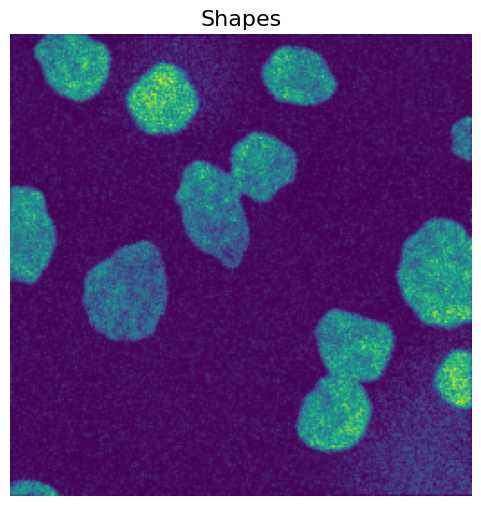

In [22]:
fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax1.imshow(img)
ax1.set_title('Shapes',fontsize=16)
ax1.axis('off')
plt.show()

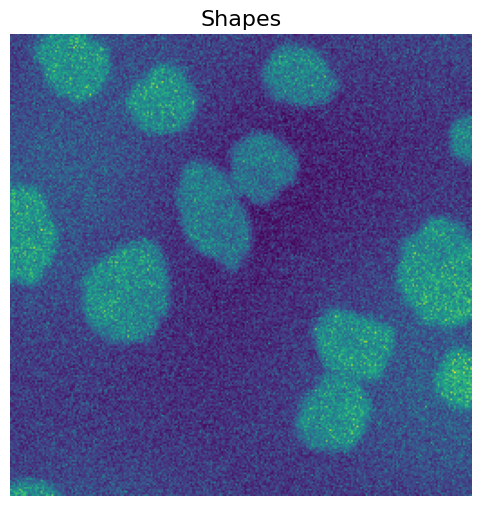

In [23]:
fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax1.imshow(final_img)
ax1.set_title('Shapes',fontsize=16)
ax1.axis('off')
plt.show()

In [ ]:
from skimage import io, util
import os

def save_image(image,mask,path):
    image_u8 = util.img_as_ubyte(image/np.max(np.abs(image)))
    io.imsave(os.path.join('dataset/generated_cells','images',  f"{path}.png"), image_u8)
    mask_u8 = util.img_as_ubyte(mask/np.max(np.abs(mask)))
    io.imsave(os.path.join('dataset/generated_cells','masks',  f"{path}.png"), mask_u8)

    image = image.astype(np.float32)
    io.imsave(os.path.join('dataset/generated_cells','images',  f"{path}.tif"), image)
    mask = mask.astype(np.float32)
    io.imsave(os.path.join('dataset/generated_cells','masks',  f"{path}.tif"), mask)

In [ ]:
for i in range(70,100):
    number_cells = np.random.randint(12, 30) # random number of cells
    image = generate_cells(number_cells,256)
    mask = image
    img = image

    # NOISE 

    bg_noise = np.zeros((256,256))
    cell_1_noise = gaussian_filter(np.abs(np.random.normal(2,2,(256,256))), sigma=2)
    #Soft edges
    soft = smooth_mask(mask)
    img = bg_noise * (1 - soft) + cell_1_noise * soft
    #Internal texture
    img = add_internal_texture(img, mask)
    #Perlin noise
    illum = perlin()
    img += illum*3.5
    #Noise 
    img = airy_psf(img)
    # Poisson noise
    img = add_camera_noise(img,exposure=10,gain=1,read_noise_sigma=2)
    img = add_correlated_noise(img, strength=0.08, beta=1.4)
    img = gaussian_filter(img,sigma = 0.5)

    # SAVE IMAGE + MASK
    save_image(img, mask, f"img_{i}")
    print(i)

70


## Cross Validation

In [4]:
# Cross validation 

from sklearn.model_selection import KFold


#from sklearn.cross_validation import KFold



In [5]:
def compute_iou(pred, mask, threshold=0.5, eps=1e-6):
    """
    pred: model output (B,1,H,W)
    mask: ground truth mask (B,1,H,W)
    """
    pred_bin = (pred > threshold).float()
    intersection = (pred_bin * mask).sum(dim=(1,2,3))
    union = (pred_bin + mask - pred_bin*mask).sum(dim=(1,2,3))
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()


In [10]:
import os
import numpy as np
from skimage import io, util
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from model import UNet


import matplotlib.pyplot as plt

learning_rate = 1e-3
batch_size = 8
num_epochs = 10

kf = KFold(n_splits=2, shuffle=True, random_state=42)
fold = 1

for train_index, valid_index in kf.split(image_paths):  # pass the list, not a string
    print(f"\n[Fold {fold}]")
    
    train_dataset = Subset(dataset, train_index)
    valid_dataset = Subset(dataset, valid_index)
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=8)


    model = UNet(n_channels=1, n_classes=1).to(device)
    


    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss()

    train_losses = []
    val_losses = []
    val_ious = []


    for epoch in range(num_epochs):
        model.train()
        running = 0.0

        for imgs, msks in train_loader:
            imgs, msks = imgs.to(device), msks.to(device)

            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, msks)
            loss.backward()
            optimizer.step()

            running += loss.item() * imgs.size(0)

        tr_loss = running / len(train_dataset)
        train_losses.append(tr_loss)

        model.eval()
        val_running = 0.0
        iou_running = 0.0

        with torch.no_grad():
            for imgs, msks in valid_loader:
                imgs, msks = imgs.to(device), msks.to(device)
                out = model(imgs)

                vloss = criterion(out, msks)
                val_running += vloss.item() * imgs.size(0)

                
                iou_running += compute_iou(out, msks) * imgs.size(0) # compute IoU

        va_loss = val_running / len(valid_dataset)
        va_iou = iou_running / len(valid_dataset)

        val_losses.append(va_loss)
        val_ious.append(va_iou)

        print(f"Fold {fold} | Epoch {epoch+1}/{num_epochs} "
              f"Train Loss: {tr_loss:.4f} | Val Loss: {va_loss:.4f} | IoU: {va_iou:.4f}")

    
    epochs_range = range(1, num_epochs + 1)

    plt.figure(figsize=(10,5))
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Fold {fold} – Loss Curves")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(epochs_range, val_ious, label="Val IoU")
    plt.xlabel("Epoch")
    plt.ylabel("IoU")
    plt.title(f"Fold {fold} – IoU Curve")
    plt.legend()
    plt.show()

    

    fold += 1


NameError: name 'dataset' is not defined

In [ ]:
pip install torch torchvision torchaudio
